<a href="https://colab.research.google.com/github/Kushvith/face_recognization_using_siamese_neural_network/blob/main/face_recognization_using_siamese_neural_network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plot

In [ ]:
# import dependencies for functional Api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,MaxPooling2D,Dense,Input,Flatten
import tensorflow as tf


# Set GPU Growth

In [ ]:
# avoid the out memory errors by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

#Create the path directories

In [ ]:
# setup paths
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negative')
anc_path = os.path.join('data','anchor')



In [ ]:
# make the directories
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

#Downloading the untar Labelled bfaces from wild Dataset

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2023-09-10 16:26:17--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  1.80MB/s    in 1m 44s  

2023-09-10 16:28:01 (1.66 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
#unzip tar file
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
      Ex_path = os.path.join('lfw',directory,file)
      New_path = os.path.join(neg_path,file)
      os.replace(Ex_path,New_path)

#collecting the positive and anchor images from classes

In [ ]:
#import uuid library is used for generating the uniform unique id
import uuid
uuid.uuid1()

UUID('044d32f4-4ff7-11ee-9055-0242ac1c000c')

In [ ]:
# this step is performed in jupyter notebook for collecting images using opencv language

cap = cv2.VideoCapture(1)
while cap.isOpened():
  ret,frame = cap.read()
  frame = frame[120:120+250,200:200+250,:]
  cv2.imshow("Image collection",frame)
  # collecting images of achor
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imname = os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imname,frame)
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imname = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imname,frame)

  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()


In [ ]:
#  Extracting the files

ARCHIVE_FILES = os.path.join('archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  print("extracting")
  !tar -zxvf {ARCHIVE_FILES}

extracting
data/positive/
data/positive/9f2a6e6b-4d6e-11ee-9166-ac1203894977.jpg
data/positive/9f33d0ff-4d6e-11ee-aa66-ac1203894977.jpg
data/positive/9f3dd9c6-4d6e-11ee-944c-ac1203894977.jpg
data/positive/9f460acb-4d6e-11ee-ae91-ac1203894977.jpg
data/positive/9f70a26a-4d6e-11ee-902f-ac1203894977.jpg
data/positive/9f782bb1-4d6e-11ee-bf12-ac1203894977.jpg
data/positive/9f84cd4e-4d6e-11ee-9f02-ac1203894977.jpg
data/positive/9f8e3659-4d6e-11ee-a526-ac1203894977.jpg
data/positive/9fafe4b8-4d6e-11ee-a90c-ac1203894977.jpg
data/positive/9fbca61f-4d6e-11ee-93de-ac1203894977.jpg
data/positive/9fd4c339-4d6e-11ee-b5d5-ac1203894977.jpg
data/positive/9ff468f4-4d6e-11ee-9bfe-ac1203894977.jpg
data/positive/a01eacf0-4d6e-11ee-bc92-ac1203894977.jpg
data/positive/a0abfcbd-4d6e-11ee-ab24-ac1203894977.jpg
data/positive/a0b293a5-4d6e-11ee-842f-ac1203894977.jpg
data/positive/a0beef5f-4d6e-11ee-9249-ac1203894977.jpg
data/positive/a0ee51f9-4d6e-11ee-8574-ac1203894977.jpg
data/positive/a0f7d60f-4d6e-11ee-b073-a

In [ ]:
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(75)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(75)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)


In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test.next()

b'data/anchor/7f2b93ea-4d6e-11ee-af97-ac1203894977.jpg'

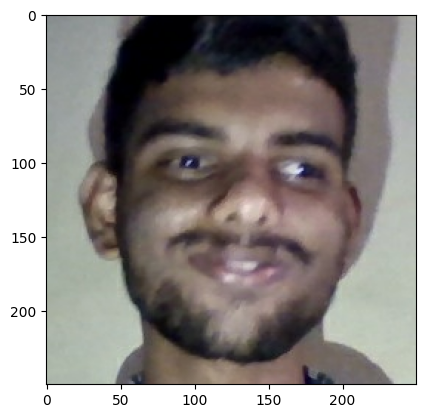

In [ ]:
byte_img = tf.io.read_file('data/anchor/6809a000-4d6e-11ee-a879-ac1203894977.jpg')
img = tf.io.decode_jpeg(byte_img)
plot.imshow(img)

# preprocess or rescale the image

In [ ]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img,(100,100))
  img /=255.0
  return img

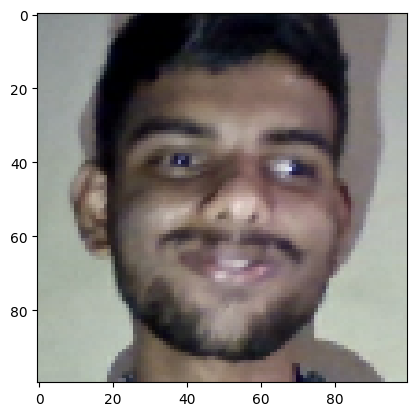

In [ ]:
img = preprocess('data/anchor/6809a000-4d6e-11ee-a879-ac1203894977.jpg')
plot.imshow(img)

In [ ]:
# tensor_slices will load the data into dataset and then can be used as iterator
class_llabels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
class_llabels.as_numpy_iterator()

In [ ]:

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [ ]:
samples = data.as_numpy_iterator()


In [ ]:
examples = samples.next()

In [ ]:
examples

(b'data/anchor/7fd95a56-4d6e-11ee-8f30-ac1203894977.jpg',
 b'data/positive/a232e14f-4d6e-11ee-9cd0-ac1203894977.jpg',
 1.0)

# Build Train and test partition

In [ ]:
def preprocess_twin(input_img,validation_img,label):
  return (preprocess(input_img),preprocess(validation_img),label)

In [ ]:
res = preprocess_twin(*examples)

In [ ]:
len(res)

3

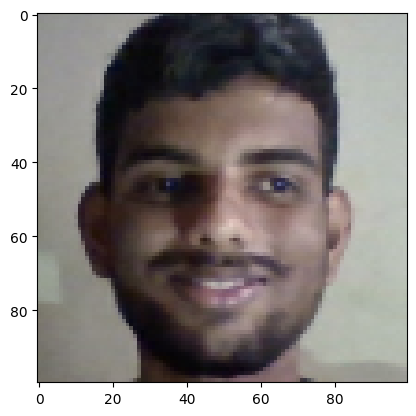

In [ ]:
plot.imshow(res[0])

# Build dataLoader pipleine for training and testing

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
#training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
train_samples = train_data.as_numpy_iterator()

In [ ]:
train_sample = train_samples.next()
len(train_sample)

3

In [ ]:
len(train_sample[0])

16

In [ ]:
train_sample[0]

array([[[[0.6129902 , 0.6482843 , 0.6286765 ],
         [0.59387255, 0.62916666, 0.61740196],
         [0.5767157 , 0.6120098 , 0.60612744],
         ...,
         [0.6872549 , 0.71887255, 0.71813726],
         [0.72205883, 0.73970586, 0.74264705],
         [0.74019605, 0.7480392 , 0.74215686]],

        [[0.6098039 , 0.64215684, 0.62352943],
         [0.5990196 , 0.6313726 , 0.62058824],
         [0.5835784 , 0.60784316, 0.6       ],
         ...,
         [0.610049  , 0.63529414, 0.6610294 ],
         [0.7004902 , 0.7142157 , 0.7348039 ],
         [0.72769606, 0.7316176 , 0.74583334]],

        [[0.6127451 , 0.6333333 , 0.61764705],
         [0.59117645, 0.60882354, 0.6039216 ],
         [0.5742647 , 0.59044117, 0.5862745 ],
         ...,
         [0.55784315, 0.57941175, 0.6313726 ],
         [0.6428922 , 0.65563726, 0.6931372 ],
         [0.717402  , 0.72132355, 0.73995095]],

        ...,

        [[0.41764706, 0.4019608 , 0.3647059 ],
         [0.42058823, 0.40490195, 0.36764705]

In [ ]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering


## Build Make Embedding layer

In [ ]:
def  make_embedding():
  inp = Input(shape=(100,100,3),name="Input_Image")
  # first block
  c1 = Conv2D(64,(10,10),activation='relu')(inp)
  m1 = MaxPooling2D(64,(2,2),padding="same")(c1)
  # second block
  c2 = Conv2D(128,(7,7),activation="relu")(m1)
  m2 = MaxPooling2D(64,(2,2),padding="same")(c2)
  # third layer
  c3 = Conv2D(128,(4,4),activation="relu")(m2)
  m3 = MaxPooling2D(64,(2,2),padding="same")(c3)
  # fourth layer

  # fifth layer
  c5 = Conv2D(256,(4,4),activation="relu")(m3)
  f1 = Flatten()(c5)
  c6 = Dense(4096,activation="sigmoid",name="output_layer")(f1)
  return Model(inputs=[inp],outputs=[c6],name="embedding")

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## Build distance layer

In [ ]:
class L1Dist(Layer):
  def __init__(self,**kwargs):
    super().__init__()
    # Magic haooens Here
  def call(self,input_embedding,validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

In [ ]:
def make_siemse_model():
  #ANchor input
  input_image = Input(name="input_img",shape=(100,100,3))
  # validattion input
  validation_image = Input(name="validation_img",shape=(100,100,3))
  # combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image),embedding(validation_image))
  # classification layer
  classifier = Dense(1,activation="sigmoid")(distances)
  return Model(inputs=[input_image,validation_image],outputs=classifier,name="simeseNetwork")


In [ ]:
siamese_model = make_siemse_model()

In [ ]:
siamese_model.summary()

Model: "simeseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                      

#training the model

In [ ]:
binary_crossentroy = tf.losses.BinaryCrossentropy()
opt = tf.optimizers.Adam(1e-4)

## Establish the checkpoints

In [ ]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint = tf.train.Checkpoint(tf.keras.optimizers.Adam(1e-4),siamese_model=siamese_model)


## training the model

In [ ]:
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    # get anchor of positive or negative image
    x = batch[:2]
    # get label
    y = batch[2]
    yhat = siamese_model(x,training=True)
    loss = binary_crossentroy(y,yhat)
  print(loss)
  grad = tape.gradient(loss,siamese_model.trainable_variables)
  opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
  return loss


In [ ]:
def train(data,epochs):
  for epoch in range(1,epochs+1):
    print("\n Epoch {}/{}".format(epoch,epochs))
    progbar = tf.keras.utils.Progbar(len(data))

    for idx,batch in enumerate(data):
      train_step(batch)
      progbar.update(idx+1)
      if epoch %10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
epochs = 50

In [ ]:
train(train_data,epochs)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
7/7 [==============================] - 16s 273ms/step

 Epoch 2/50
7/7 [==============================] - 1s 185ms/step

 Epoch 3/50
7/7 [==============================] - 1s 185ms/step

 Epoch 4/50
7/7 [==============================] - 1s 187ms/step

 Epoch 5/50
7/7 [==============================] - 1s 186ms/step

 Epoch 6/50
7/7 [==============================] - 1s 188ms/step

 Epoch 7/50
7/7 [==============================] - 1s 189ms/step

 Epoch 8/50
7/7 [==============================] - 1s 188ms/step

 Epoch 9/50
7/7 [==============================] - 1s 187ms/step

 Epoch 10/50
7/7 [==============================] - 4s 584ms/step

 Epoch 11/50
7/7 [==============================] - 1s 200ms/step

 Epoch 12/50
7/7 [==============================] - 1s 188ms/step

 Epoch 13/50
7/7 [==============================]

# Evalute the model

In [ ]:
from tensorflow.keras.metrics import Precision,Recall

In [ ]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()


In [ ]:
# make some predictions
yhat = siamese_model.predict([test_input,test_val])
yhat

1/1 [==============================] - 0s 178ms/step


array([[6.66381368e-08],
       [9.25967925e-08],
       [2.47297212e-05],
       [6.31962303e-06],
       [1.33483445e-05],
       [9.99999285e-01],
       [1.73899053e-07],
       [8.53162703e-07],
       [9.99999881e-01],
       [9.99998927e-01],
       [3.88084906e-08],
       [1.00000000e+00],
       [9.99990106e-01],
       [9.99998927e-01],
       [9.99998569e-01],
       [1.27858823e-06]], dtype=float32)

In [ ]:
[1 if prediction > 0.5 else 0 for prediction in yhat]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]

In [ ]:
y_true

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [ ]:
# calculating the recall value of model
m = Recall()
m.update_state(y_true,yhat)
m.result().numpy()

1.0

In [ ]:
# calculating the Precision value of model
m = Precision()
m.update_state(y_true,yhat)
m.result().numpy()

1.0

# comparing the results


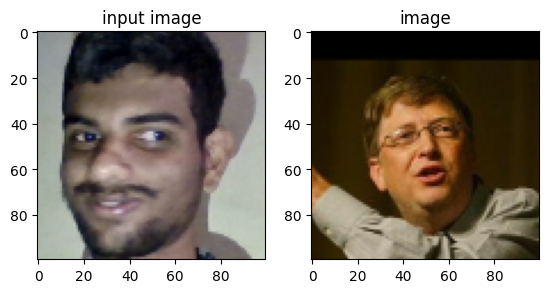

In [ ]:
plot.figure(figsize=(10,7))
plot.subplot(1,3,1)
plot.title("input image")
plot.imshow(test_input[3])
plot.subplot(1,3,2)
plot.title("image")
plot.imshow(test_val[3])
plot.show()

# save model

In [ ]:
siamese_model.save("siamese_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('siamese_model.h5',
                            custom_objects={
                                'L1Dist':L1Dist,
                                'BinaryCrossentropy':tf.losses.BinaryCrossentropy
                            })

In [ ]:
model.predict([test_input,test_val])

1/1 [==============================] - 0s 193ms/step


array([[6.66381368e-08],
       [9.25967925e-08],
       [2.47297212e-05],
       [6.31962303e-06],
       [1.33483445e-05],
       [9.99999285e-01],
       [1.73899053e-07],
       [8.53162703e-07],
       [9.99999881e-01],
       [9.99998927e-01],
       [3.88084906e-08],
       [1.00000000e+00],
       [9.99990106e-01],
       [9.99998927e-01],
       [9.99998569e-01],
       [1.27858823e-06]], dtype=float32)